In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
# sklearnx for speedup
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, roc_auc_score


In [4]:
X_test_raw = pd.read_csv('data/test_set_features.csv')

X_train_raw = pd.read_csv('data/training_set_features.csv')
y_train_raw = pd.read_csv('data/training_set_labels.csv')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, test_size=0.33)

In [5]:
X_train_raw.shape

(26707, 36)

In [5]:
X_train_half = X_train_raw[:X_train_raw.shape[0]//2]
y_train_half = y_train_raw[:X_train_raw.shape[0]//2]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train_half, y_train_half, test_size=0.33)

In [9]:
X_train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
12345,12345,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lzgpxyit,"MSA, Principle City",1.0,0.0,NaN,NaN
16317,16317,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,bhuqouqj,Non-MSA,1.0,0.0,pxcmvdjn,xgwztkwe
18,18,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,"> $75,000",Married,Own,Employed,oxchjgsf,Non-MSA,2.0,0.0,wlfvacwt,xgwztkwe
8406,8406,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,oxchjgsf,"MSA, Not Principle City",2.0,1.0,saaquncn,mxkfnird
18245,18245,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,atmpeygn,"MSA, Principle City",0.0,0.0,cfqqtusy,ukymxvdu


In [10]:
y_train.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
12345,12345,0,1
16317,16317,0,0
18,18,0,0
8406,8406,0,0
18245,18245,0,0


In [ ]:
# important columns: h1n1_concern, h1n1_knowledge, 

In [ ]:
# interger encode: education, income_poverity
# one hot encode: age_group, race, sex
                # marital status, rent_or_own, employment_status
                # hhs_geo_region, census_msa, employment_industry,
                # employment_occupation
# age_group	55 - 64 Years
# education	< 12 Years
# race	White
# sex	Female
# income_poverty	Below Poverty
# marital_status	Not Married
# rent_or_own	Own
# employment_status	Not in Labor Force
# hhs_geo_region	oxchjgsf
# census_msa	Non-MSA
# household_adults	0
# household_children	0
# employment_industry	NaN
# employment_occupation	NaN

In [ ]:
# column transformer
    # integer encode ordinal
    # one hot encode nominal
# build pipeline to predict
# try out diff predictors

In [6]:
X_train.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

# EDA

In [55]:
X_train.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

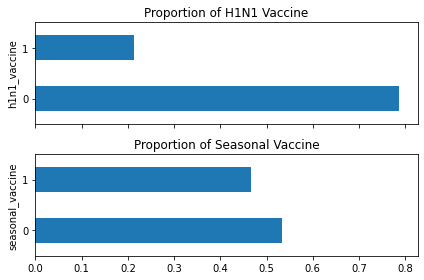

In [60]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = y_train_raw.shape[0]

(y_train_raw['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(y_train_raw['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [62]:
# see if variables are independent
pd.crosstab(
    y_train_raw["h1n1_vaccine"], 
    y_train_raw["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [63]:
# Phi Coefficient is the same as Pearson for two binary variables
(y_train_raw["h1n1_vaccine"]
     .corr(y_train_raw["seasonal_vaccine"], method="pearson")
)

0.37714265306144684

In [64]:
# finding which cols might be correlated with target variable

In [11]:
joined_raw = X_train_raw.merge(y_train_raw, on='respondent_id')

In [78]:
test_counts = joined_raw.groupby(by=['h1n1_concern', 'h1n1_vaccine'])['respondent_id'].count().unstack('h1n1_vaccine')
test_counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


In [83]:
# get normalized counts
full_counts = test_counts.sum(axis=1)
counts_props = test_counts.div(full_counts, axis='index')
counts_props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


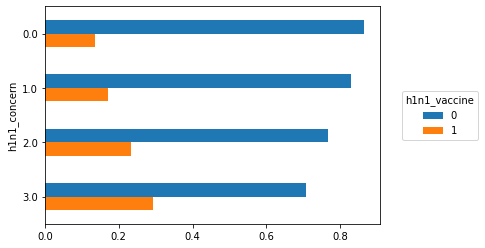

In [84]:
ax = counts_props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [9]:
# create function to plot props
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_raw[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

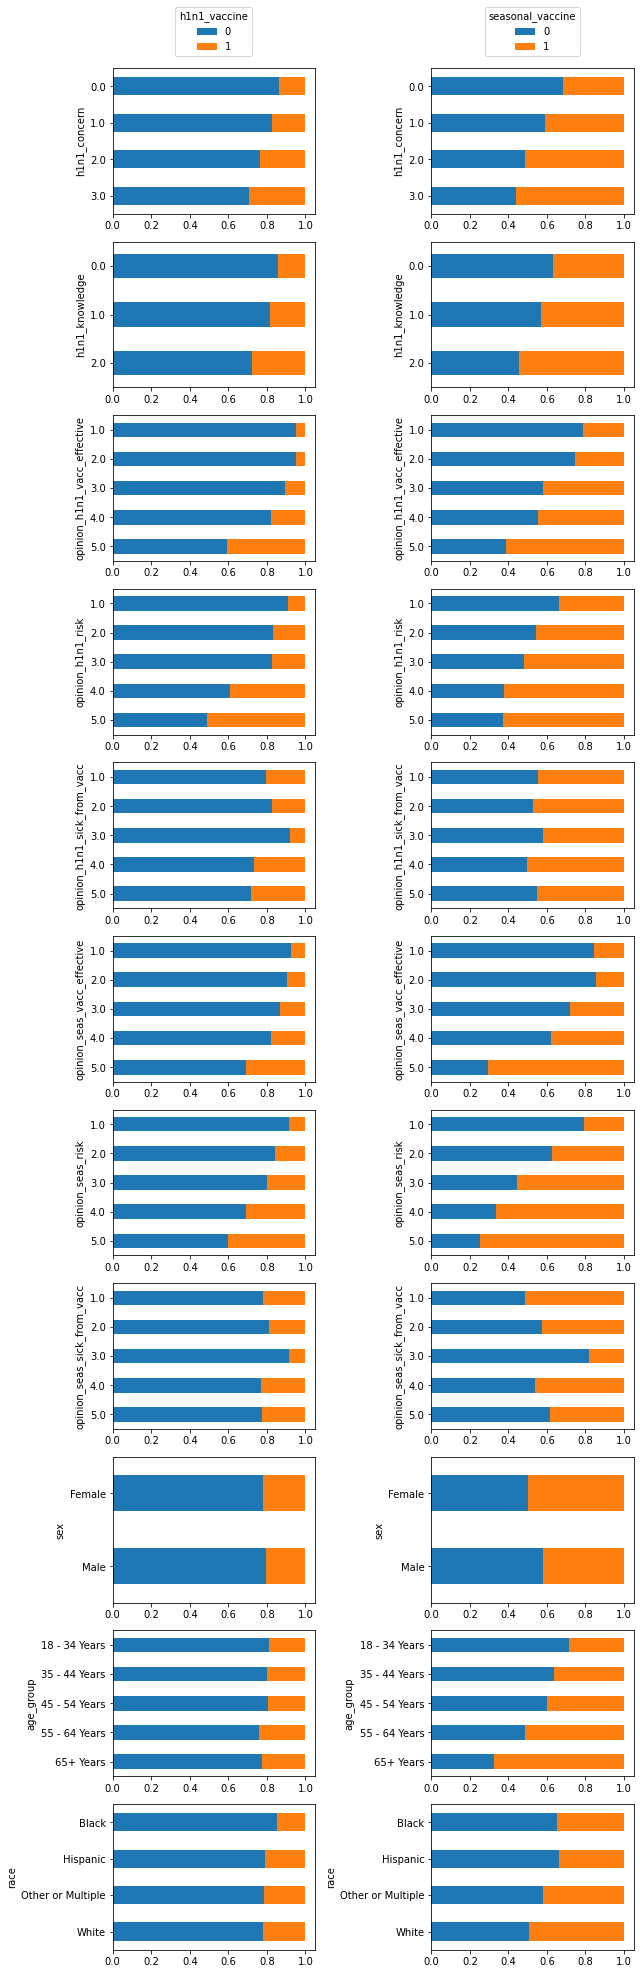

In [9]:
# plot
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_raw, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_raw, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

# Baseline Model

In [ ]:
# try out simple linear classifier using the cols 
# that are already transformed

# 'h1n1_concern', 'h1n1_knowledge',
# 'behavioral_antiviral_meds', 'behavioral_avoidance',
# 'behavioral_face_mask', 'behavioral_wash_hands',
# 'behavioral_large_gatherings', 'behavioral_outside_home',
# 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
# 'chronic_med_condition', 'child_under_6_months', 'health_worker',
# 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
# 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
# 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'


In [ ]:
# drop na, join on id, 

In [20]:
X_base_train_cols = X_train.iloc[:, 0:22]
X_base_train_cols = X_base_train_cols.dropna()
X_base_test_cols = X_test.iloc[:,0:22].dropna()

# merge
full_dropped_train = X_base_train_cols.merge(y_train, how='left', on='respondent_id')
X_base_train = full_dropped_train.iloc[:, 1:-2]
y_base_train = full_dropped_train.iloc[:, -2:]

full_dropped_test = X_base_test_cols.merge(y_test, how='left', on='respondent_id')
X_base_test = full_dropped_test.iloc[:, 1:-2] # get all cols minus respondent_id and target vars
y_base_test = full_dropped_test.iloc[:, -2:] # target vars

In [22]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_base_train, y_base_train)

In [51]:
base_preds = clf.predict_proba(X_base_test)
base_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": base_preds[0][:, 1],
        "seasonal_vaccine": base_preds[1][:, 1],
    }
)

In [52]:
roc_auc_score(y_base_test, base_preds_pd)

0.8556903184753176

# Find most Correlated Columns

In [11]:
# Find features with correlation

In [45]:
# merge y_train_raw and X_train_raw
raw_merged = X_train_raw.merge(y_train_raw, on='respondent_id')

In [ ]:
# use spearman cuz don't know if linear relationship

In [27]:
# get correlations between features and h1n1_vaccine
raw_merged.corr(method='spearman').iloc[:-2,-2].sort_values(ascending=False)

doctor_recc_h1n1               0.393890
opinion_h1n1_risk              0.305840
opinion_h1n1_vacc_effective    0.291602
opinion_seas_risk              0.256199
doctor_recc_seasonal           0.209864
opinion_seas_vacc_effective    0.195961
health_worker                  0.169768
h1n1_concern                   0.122666
health_insurance               0.121170
h1n1_knowledge                 0.120748
chronic_med_condition          0.095207
behavioral_wash_hands          0.074712
behavioral_touch_face          0.071648
behavioral_face_mask           0.070498
child_under_6_months           0.066962
opinion_h1n1_sick_from_vacc    0.059032
behavioral_avoidance           0.047690
behavioral_antiviral_meds      0.040608
behavioral_outside_home        0.021768
behavioral_large_gatherings    0.017822
household_adults               0.013360
household_children            -0.002012
opinion_seas_sick_from_vacc   -0.002808
respondent_id                 -0.003280
Name: h1n1_vaccine, dtype: float64

In [29]:
# get correlations between features and seasonal_vaccine
raw_merged.corr(method='spearman').iloc[:-2,-1].sort_values(ascending=False)

opinion_seas_vacc_effective    0.397874
opinion_seas_risk              0.389286
doctor_recc_seasonal           0.369190
opinion_h1n1_risk              0.219161
opinion_h1n1_vacc_effective    0.201753
health_insurance               0.200858
doctor_recc_h1n1               0.198607
chronic_med_condition          0.170174
h1n1_concern                   0.154467
health_worker                  0.127311
h1n1_knowledge                 0.121633
behavioral_touch_face          0.120228
behavioral_wash_hands          0.112414
behavioral_avoidance           0.076395
behavioral_large_gatherings    0.064025
behavioral_outside_home        0.053509
behavioral_face_mask           0.050083
opinion_h1n1_sick_from_vacc    0.030128
child_under_6_months           0.012097
behavioral_antiviral_meds      0.006277
respondent_id                 -0.004652
household_adults              -0.058912
opinion_seas_sick_from_vacc   -0.075427
household_children            -0.121141
Name: seasonal_vaccine, dtype: float64

In [ ]:
# take the top however many correlated features, test diff combos, and see what produces best results

# 'doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 
# 'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 

In [14]:
X_train_corr_cols = X_train[['respondent_id', 'doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 
                            'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective']]
X_train_corr_cols = X_train_corr_cols.dropna()
X_test_corr_cols = X_test[['respondent_id', 'doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 
                            'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective']]\
                            .dropna()

# merge
corr_cols_train = X_train_corr_cols.merge(y_train, how='left', on='respondent_id')
X_corr_train = corr_cols_train.iloc[:, 1:-2]
y_corr_train = corr_cols_train.iloc[:, -2:]

corr_cols_test = X_test_corr_cols.merge(y_test, how='left', on='respondent_id')
X_corr_test = corr_cols_test.iloc[:, 1:-2] # get all cols minus respondent_id and target vars
y_corr_test = corr_cols_test.iloc[:, -2:] # target vars



corr_fit = RidgeClassifierCV().fit(X_corr_train, y_corr_train)

In [15]:
corr_preds = corr_fit.decision_function(X_corr_test)

In [16]:
roc_auc_score(y_corr_test, corr_preds)

0.820134952999298

In [6]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_base_train, y_base_train)

NameError: name 'X_base_train' is not defined

In [51]:
base_preds = clf.predict_proba(X_base_test)
base_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": base_preds[0][:, 1],
        "seasonal_vaccine": base_preds[1][:, 1],
    }
)

In [52]:
roc_auc_score(y_base_test, base_preds_pd)

0.8556903184753176

# Baseline (pipeline)

In [6]:
# get numeric columns
numeric_cols = X_train_raw.columns[X_train_raw.dtypes != "object"].values

In [7]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [8]:
# Estimator
estimators = MultiOutputClassifier(
            estimator=LogisticRegression(penalty='l2', C=1)
)

In [9]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

In [33]:
# training
# 332.3885486125946 w sklearnx
start = time.time()
full_pipeline.fit(X_train, y_train)
end = time.time()
print(end-start)

60.535948514938354


In [34]:
base_preds = full_pipeline.predict_proba(X_test)
base_preds

[array([[1.57669569e-05, 2.13029981e-05, 2.35167320e-05, ...,
         2.79076760e-05, 2.24072526e-05, 1.75030547e-05],
        [7.47600062e-06, 2.81585933e-04, 7.10956864e-06, ...,
         1.12834186e-05, 1.44876772e-04, 2.35622382e-04],
        [1.03702233e-04, 1.27851080e-05, 3.67970253e-06, ...,
         3.78126059e-04, 1.79955236e-05, 4.59019943e-05],
        ...,
        [8.14598253e-06, 1.21867135e-06, 1.35439620e-04, ...,
         7.33038123e-07, 3.55148038e-06, 4.46196485e-07],
        [9.56583006e-07, 7.78860866e-06, 1.26619306e-05, ...,
         1.41879370e-05, 4.39786564e-06, 2.80517225e-05],
        [7.71524668e-06, 8.40143298e-06, 6.54272075e-06, ...,
         6.31137597e-05, 1.95962978e-06, 1.83191835e-05]]),
 array([[0.63899192, 0.36100808],
        [0.78270814, 0.21729186],
        [0.96182981, 0.03817019],
        ...,
        [0.83970766, 0.16029234],
        [0.5439187 , 0.4560813 ],
        [0.85952993, 0.14047007]]),
 array([[0.41545099, 0.58454901],
        [0.3

In [35]:
base_preds_pd = pd.DataFrame({
    'h1n1_vaccine': base_preds[1][:,1],
    'seasonal_vaccine': base_preds[2][:,1]
}, index=y_test.index)

roc_auc_score(y_test[['h1n1_vaccine', 'seasonal_vaccine']], base_preds_pd)

0.8365636402626393

In [10]:
start = time.time()
# train on full training set
full_pipeline.fit(X_train_raw, y_train_raw)
end = time.time()
print(end - start)

567.3303442001343


In [13]:
full_preds = full_pipeline.predict_proba(X_test_raw)

In [15]:
full_preds

[array([[5.18643325e-08, 1.09253472e-06, 9.60444878e-07, ...,
         1.43715974e-04, 1.05141949e-05, 3.31202686e-05],
        [4.71959717e-07, 3.41221278e-09, 2.14215587e-05, ...,
         9.68808753e-08, 1.85326698e-03, 1.94764728e-04],
        [1.20828358e-07, 7.49941294e-06, 8.75432024e-09, ...,
         6.02694379e-03, 2.50588666e-06, 1.69498468e-07],
        ...,
        [2.07289297e-08, 2.96988798e-10, 1.80482744e-08, ...,
         3.64814570e-05, 2.52313317e-04, 1.70382634e-03],
        [2.96908259e-09, 1.71023221e-08, 2.83053857e-09, ...,
         8.15462747e-06, 4.59558612e-06, 3.08436107e-06],
        [8.47556011e-09, 4.88084368e-09, 1.72240495e-10, ...,
         8.64713508e-05, 7.97155354e-05, 3.62628170e-05]]),
 array([[0.87354879, 0.12645121],
        [0.94510339, 0.05489661],
        [0.63066178, 0.36933822],
        ...,
        [0.80735853, 0.19264147],
        [0.9502145 , 0.0497855 ],
        [0.38909545, 0.61090455]]),
 array([[0.57767773, 0.42232227],
        [0.9

In [19]:
full_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": full_preds[1][:, 1],
        "seasonal_vaccine": full_preds[2][:, 1],
    }, index=X_test_raw.respondent_id
)

In [32]:
full_preds_pd.to_csv('submissions/baseline_preds.csv', index=True)

# Submission

In [ ]:
submission_df.to_csv('my_submission.csv', index=True)

# Find Best Features

In [ ]:
joined_half = X_train_half.merge(y_train_half, on='respondent_id')

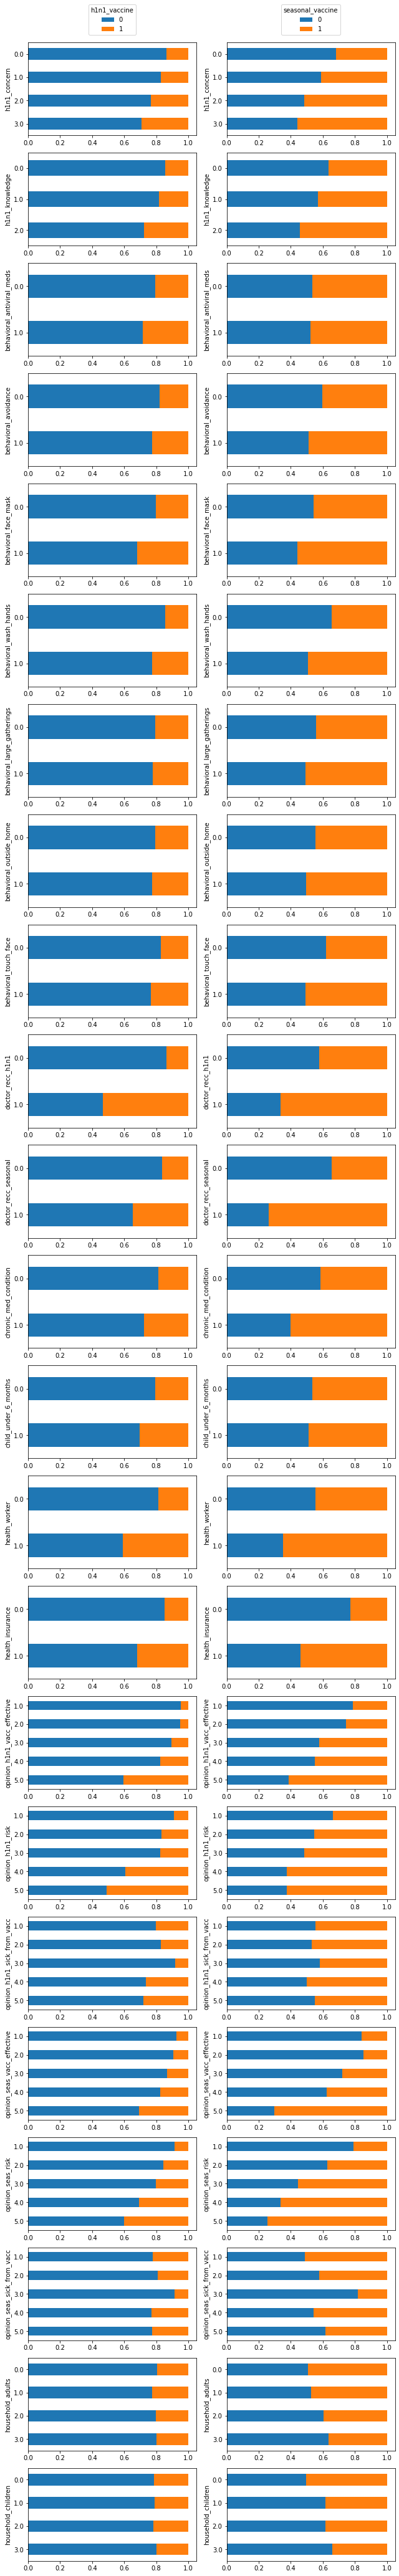

In [15]:
# use all numeric cols except respondent cols
cols_to_plot = list(numeric_cols[1:])

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_raw, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_raw, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

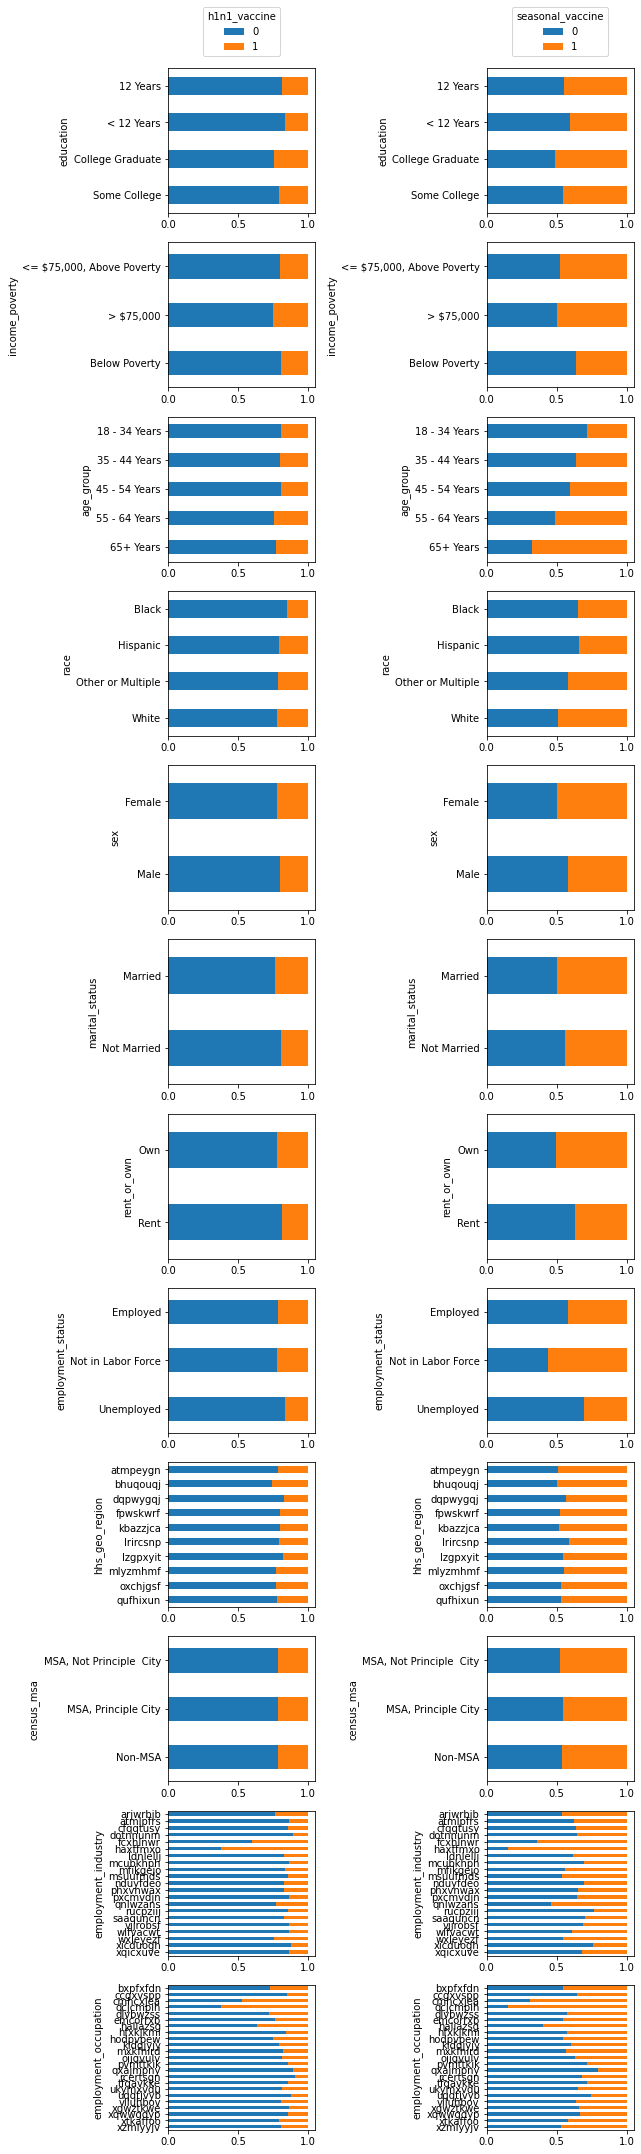

In [13]:
# plot
cols_to_plot = [
    'education', 
    'income_poverty',
    'age_group', 
    'race', 
    'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 
    'census_msa', 'employment_industry', 'employment_occupation'
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_raw, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_raw, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

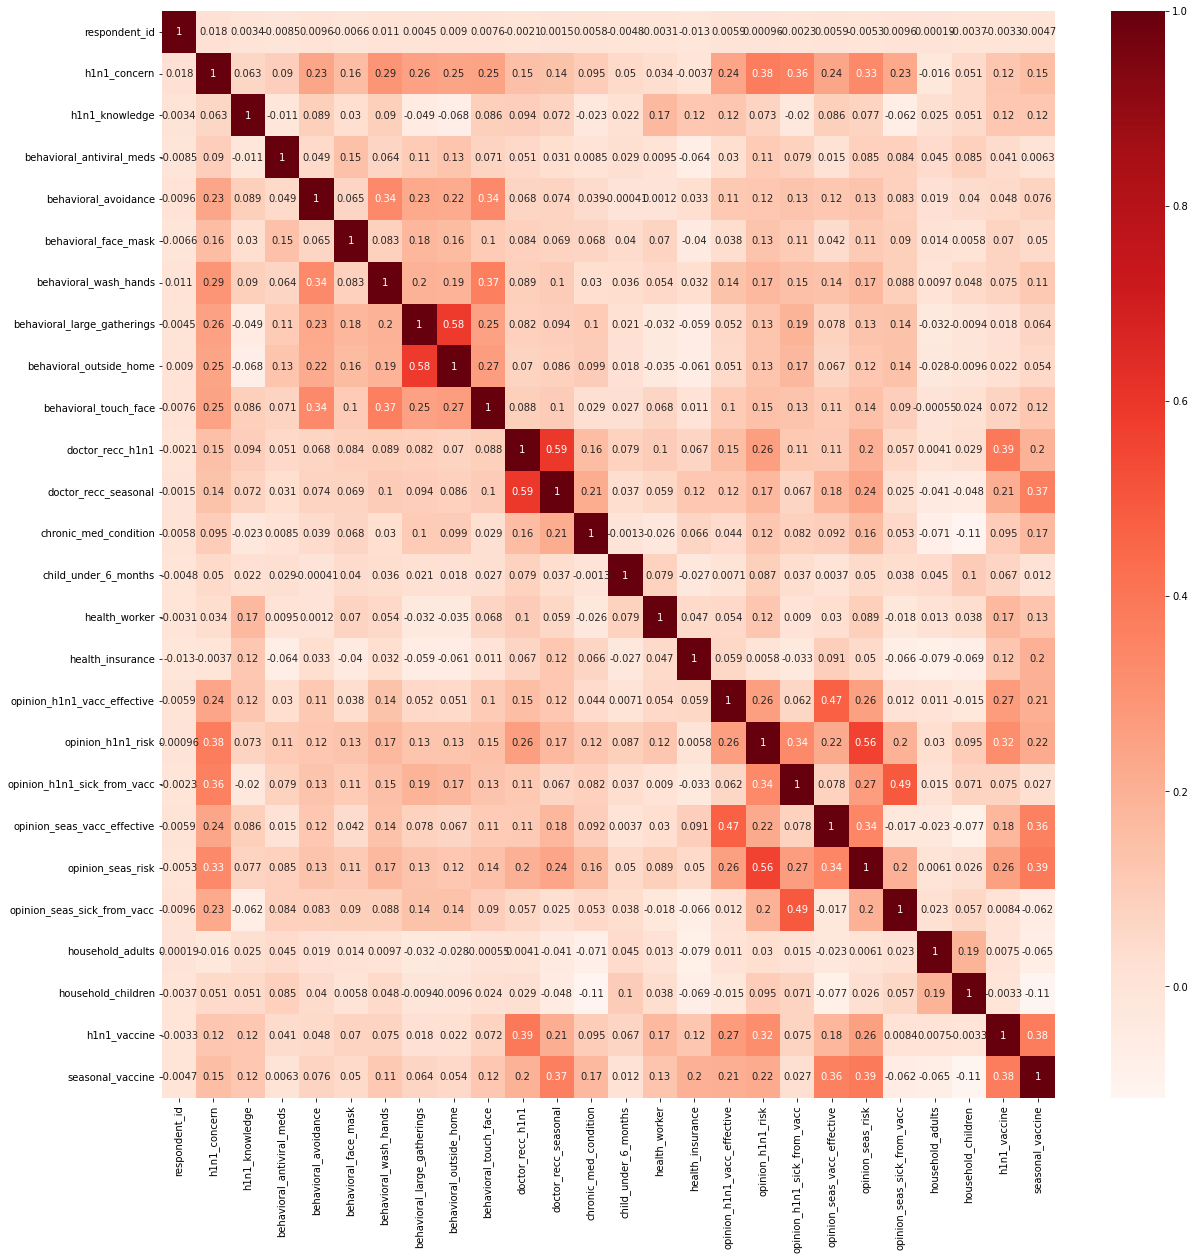

In [48]:
plt.figure(figsize=(20,20))
cor = raw_merged.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
feat_cols = ['h1n1_concern', 
             'h1n1_knowledge',
             'behavioral_face_mask', 
             'behavioral_wash_hands', 
             'doctor_recc_h1n1',
             'doctor_recc_seasonal', 
             'chronic_med_condition', 
             'health_worker', 
             'health_insurance', 
             'opinion_h1n1_vacc_effective', 
             'opinion_h1n1_risk', 
             'opinion_seas_vacc_effective', 
             'opinion_seas_risk',
            'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']
bimodal_cols = ['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']
# interger encode: education, income_poverity
# one hot encode: age_group, race, sex
                # marital status, rent_or_own, employment_status
                # hhs_geo_region, census_msa, employment_industry,
                # employment_occupation
one_hot_cols = ['age_group','employment_industry', 'employment_occupation']


<AxesSubplot:ylabel='Count'>

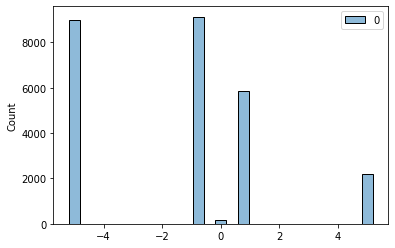

In [151]:
sns.histplot(QuantileTransformer(n_quantiles=2,output_distribution='normal').fit_transform(X_train_raw[['opinion_h1n1_sick_from_vacc']]))

In [10]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])
bimodal_preprocess = Pipeline([
    ('bimodal_normalize', QuantileTransformer(n_quantiles=3,output_distribution='normal')),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])

one_hot_encode_preprocess = Pipeline([
    ('one_hot_encode', OneHotEncoder(handle_unknown='ignore')),
    ('simple_imputer', SimpleImputer(strategy='constant')),
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, feat_cols),
#         ('bimodal', bimodal_preprocess, bimodal_cols),
        ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'), one_hot_cols)
    ],
    remainder = "drop"
)

In [15]:
# Estimator
estimators = MultiOutputClassifier(
            estimator=LogisticRegression(solver='sag', penalty='l2', C=1.5)
)

In [16]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

In [17]:
start = time.time()
full_pipeline.fit(X_train, y_train)
end = time.time()
print(end-start)

C:\Users\seann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


365.0262451171875


C:\Users\seann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\seann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# 0.8425711622586873 all feat cols, and one hot encode cols, 0.5 learning rate
# 0.8422125765538615 some feat cols, all one hotm 0.2 lr
# 0.8433907684220692 all feat - opinionsickfrom and one hot w employment occ, 0.1 lr
# 0.843365416401126 all feat except face mask wash hand
# 0.843365416401126 all w bimodal
temp_preds = full_pipeline.predict_proba(X_test)
temp_preds_pd = pd.DataFrame({
    'h1n1_vaccine': temp_preds[1][:,1],
    'seasonal_vaccine': temp_preds[2][:,1]
}, index=y_test.index)

roc_auc_score(y_test[['h1n1_vaccine', 'seasonal_vaccine']], temp_preds_pd)

0.8378490348962384

In [28]:
corr_preds = full_pipeline.predict_proba(X_test_raw)

In [29]:
corr_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": corr_preds[1][:, 1],
        "seasonal_vaccine": corr_preds[2][:, 1],
    }, index=X_test_raw.respondent_id
)

In [34]:
corr_preds_pd.to_csv('submissions/corr_preds.csv', index=True)

In [ ]:
# best feats model on full dataset

In [14]:
feat_cols = ['h1n1_concern', 
             'h1n1_knowledge',
             'behavioral_face_mask', 
             'behavioral_wash_hands', 
             'doctor_recc_h1n1',
             'doctor_recc_seasonal', 
             'chronic_med_condition', 
             'health_worker', 
             'health_insurance', 
             'opinion_h1n1_vacc_effective', 
             'opinion_h1n1_risk', 
             'opinion_seas_vacc_effective', 
             'opinion_seas_risk',
            'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']
bimodal_cols = ['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']
# interger encode: education, income_poverity
# one hot encode: age_group, race, sex
                # marital status, rent_or_own, employment_status
                # hhs_geo_region, census_msa, employment_industry,
                # employment_occupation
one_hot_cols = ['age_group','employment_industry', 'employment_occupation']


In [21]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])
bimodal_preprocess = Pipeline([
    ('bimodal_normalize', QuantileTransformer(n_quantiles=3,output_distribution='normal')),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, feat_cols),
        ('bimodal', bimodal_preprocess, bimodal_cols),
        ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'), one_hot_cols)
    ],
    remainder = "drop"
)

In [22]:
# Estimator
estimators = MultiOutputClassifier(
            estimator=LogisticRegression(penalty='l2', C=0.2)
)

In [23]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

In [24]:
start = time.time()
full_pipeline.fit(X_train_raw, y_train_raw)
end = time.time()
print(end-start)

C:\Users\seann\AppData\Local\Programs\Python\Python311\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\seann\AppData\Local\Programs\Python\Python311\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

1836.886834859848


In [25]:
best_feat_preds = full_pipeline.predict_proba(X_test_raw)

In [26]:
best_feat_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": best_feat_preds[1][:, 1],
        "seasonal_vaccine": best_feat_preds[2][:, 1],
    }, index=X_test_raw.respondent_id
)

In [27]:
best_feat_preds_pd

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.086332,0.332505
26708,0.018979,0.046816
26709,0.386554,0.587144
26710,0.441193,0.877238
26711,0.264522,0.550625
...,...,...
53410,0.259466,0.466098
53411,0.044311,0.229652
53412,0.192639,0.250214


In [28]:
best_feat_preds_pd.to_csv('submissions/best_feats_preds.csv', index=True)

# Find Best Model

In [13]:
# classifiers w predict proba
AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier # slow training
# GridSearchCV
# HalvingGridSearchCV
# HalvingRandomSearchCV
HistGradientBoostingClassifier # try this
KNeighborsClassifier
# LabelPropagation
# LabelSpreading
# LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
# Pipeline
# QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier

NameError: name 'AdaBoostClassifier' is not defined

In [ ]:
# models
LogisticRegression(penalty='l2', C=1)
DecisionTreeClassifier(min_samples_leaf=20, max_depth=20)
KNeighborsClassifier(n_neighbors=10) # not the best
RandomForestClassifier() # but kills the kernel
AdaBoostClassifier() # does pretty good 85% on test set but slowish
BaggingClassifier() # pretty quick but 80% on one run
BernoulliNB() # v fast but only 80%
GaussianNB() # fast, but have to make sure OHE spare_output=False 72% acc


In [7]:
feat_cols = ['h1n1_concern', 
             'h1n1_knowledge',
             'behavioral_face_mask', 
             'behavioral_wash_hands', 
             'doctor_recc_h1n1',
             'doctor_recc_seasonal', 
             'chronic_med_condition', 
             'health_worker', 
             'health_insurance', 
             'opinion_h1n1_vacc_effective', 
             'opinion_h1n1_risk', 
             'opinion_seas_vacc_effective', 
             'opinion_seas_risk',
            'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']
bimodal_cols = ['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']
# interger encode: education, income_poverity
# one hot encode: age_group, race, sex
                # marital status, rent_or_own, employment_status
                # hhs_geo_region, census_msa, employment_industry,
                # employment_occupation
one_hot_cols = ['age_group','employment_industry', 'employment_occupation']


In [8]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])
bimodal_preprocess = Pipeline([
    ('bimodal_normalize', QuantileTransformer(n_quantiles=3,output_distribution='normal')),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, feat_cols),
        ('bimodal', bimodal_preprocess, bimodal_cols),
        ('one_hot_encode', OneHotEncoder(handle_unknown='ignore',sparse_output=False), one_hot_cols)
    ],
    remainder = "drop"
)

In [9]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBRegressor
from sklearn.multiclass import OneVsRestClassifier

In [10]:
# Estimator
estimators = MultiOutputClassifier(
            estimator=OneVsRestClassifier(XGBRegressor(tree_method='gpu_hist', max_depth=4))
)

In [11]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

In [ ]:
start = time.time()
full_pipeline.fit(X_train, y_train)
end = time.time()
print(end-start)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000001CA47B4F710>>
Traceback (most recent call last):
  File "C:\Users\seann\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 500, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


In [ ]:
preds = full_pipeline.predict_proba(X_test)
preds

In [ ]:
preds_pd = pd.DataFrame({
    'h1n1_vaccine': preds[1][:,1],
    'seasonal_vaccine': preds[2][:,1]
}, index=y_test.index)

roc_auc_score(y_test[['h1n1_vaccine', 'seasonal_vaccine']], preds_pd)

In [7]:
# todo: find best features with correlation,
        # maybe find best for h1n1 and one for flu
        # try multilabel classifier
#      imputation for missing cols?/
#      half training dataset for faster training/
#      try out different imputers/
#      try out correlated columns (see graphs)/
#      train final features model on full dataset and submit
#      find different predictors
#      use gridsearch to find best parameters